In [1]:
from transformers import pipeline
from transformers import AutoTokenizer
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import numpy as np
import evaluate

d:\anaconda3\envs\torch\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
d:\anaconda3\envs\torch\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: htt

## 微调 测试--Trainer 形式

In [3]:
## 数据
dataset = load_dataset("yelp_review_full")
dataset["train"][100]

## 分词器
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

## 分词 获取 训练数据集
tokenized_datasets = dataset.map(tokenize_function, batched=True)

##### 小数据集
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/650000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [7]:
## eval 评测
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [6]:
## 模型--预训练模型加载与改造
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
##### 小数据集
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(160))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(16))
## 生成训练参数
training_args = TrainingArguments(output_dir="test_trainer", eval_strategy="epoch",
                                   num_train_epochs=1,per_device_train_batch_size=8)
## 生成训练器
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [2]:
## 训练 
trainer.train() #默认参数下需要1小时 epo=3, batch=8

  0%|          | 0/10 [00:00<?, ?it/s]

## Test

In [3]:
from transformers import BertConfig, BertModel

# 定义预训练模型的名称
pretrained_model_name_or_path = "bert-base-uncased"

# 加载配置文件
config = BertConfig.from_pretrained(pretrained_model_name_or_path)

# 手动初始化模型结构
model = BertModel(config)
# model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=5)
# 打印模型结构
# print(model)

In [5]:
import sys

# 打印模型结构的内存占用
print(f"Model size in memory: {sys.getsizeof(model)} bytes")
model


Model size in memory: 48 bytes


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [6]:
# model1 = BertModel.from_pretrained(pretrained_model_name_or_path)
# print(f"Model size in memory: {sys.getsizeof(model1)} bytes")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

d:\anaconda3\envs\torch\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in D:\work\cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Model size in memory: 48 bytes


## 微调-冻结预训练参数

In [2]:
## 数据
dataset = load_dataset("yelp_review_full")
dataset["train"][100]

## 分词器
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

## 分词 获取 训练数据集
tokenized_datasets = dataset.map(tokenize_function, batched=True)

##### 小数据集
# small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
# small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))
## eval 评测
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

## 模型--预训练模型加载与改造
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# from transformers import AdamW
# import torch
# 冻结预训练层的参数
for param in model.bert.parameters():
    param.requires_grad = False

In [6]:
# 定义训练参数
training_args = TrainingArguments(
    output_dir="test_trainer",
    eval_strategy="epoch",
    num_train_epochs=1,
    per_device_train_batch_size=8
)


small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(500))
# 定义 Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)



In [7]:
# 训练模型
trainer.train()
# 冻结预训练层
# {'eval_loss': 1.6022945642471313, 'eval_accuracy': 0.22, 'eval_runtime': 24.1237, 
#  'eval_samples_per_second': 20.726, 'eval_steps_per_second': 2.612, 'epoch': 1.0}
# {'train_runtime': 89.9358, 'train_samples_per_second': 11.119, 'train_steps_per_second': 1.39, 
#  'train_loss': 1.633391845703125, 'epoch': 1.0}

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 1.6022945642471313, 'eval_accuracy': 0.22, 'eval_runtime': 24.1237, 'eval_samples_per_second': 20.726, 'eval_steps_per_second': 2.612, 'epoch': 1.0}
{'train_runtime': 89.9358, 'train_samples_per_second': 11.119, 'train_steps_per_second': 1.39, 'train_loss': 1.633391845703125, 'epoch': 1.0}


TrainOutput(global_step=125, training_loss=1.633391845703125, metrics={'train_runtime': 89.9358, 'train_samples_per_second': 11.119, 'train_steps_per_second': 1.39, 'total_flos': 263118142464000.0, 'train_loss': 1.633391845703125, 'epoch': 1.0})

In [17]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)
    print('d')
    break

bert.embeddings.word_embeddings.weight False
d


## 微调-不同学习率

In [3]:
from torch.optim import AdamW, lr_scheduler

# 加载预训练的 BERT 模型，并将输出层的标签数量设置为 5
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=5)

# 定义不同的学习率
learning_rate_bert = 1e-5
learning_rate_classifier = 1e-4

# 定义优化器
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if "bert" in n],
        "lr": learning_rate_bert,
    },
    {
        "params": [p for n, p in model.named_parameters() if "classifier" in n],
        "lr": learning_rate_classifier,
    },
]

optimizer = AdamW(optimizer_grouped_parameters)

# 定义学习率调度器（可选）
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

# 定义训练参数
training_args = TrainingArguments(
    output_dir="test_trainer",
    eval_strategy="epoch",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    logging_dir="./logs",
    logging_steps=10,
)
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(500))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(100))
# 定义 Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler),
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:

# 训练模型
trainer.train()

  0%|          | 0/63 [00:00<?, ?it/s]

## 测试tokennizer

In [2]:
## 分词器
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-72B")

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

d:\anaconda3\envs\torch\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in D:\work\cache\huggingface\hub\models--Qwen--Qwen2.5-72B. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [4]:
a='今天天气不错'
tokenizer(a)

{'input_ids': [100644, 104307, 100832], 'attention_mask': [1, 1, 1]}

In [5]:
tokenizer.encode(a)

[100644, 104307, 100832]

In [6]:
tokenizer.decode(100644)

'今天'

In [10]:
vocab=tokenizer.vocab

### 中文vocab中的乱码问题

In [14]:
tokenizer.decode(vocab["éĻįå¹ħ"])

'降幅'

In [21]:
text = "helloxxx模型在信息检索中的应用"
inputs = tokenizer(text)
input_ids = inputs["input_ids"]
tokens = tokenizer.convert_ids_to_tokens(input_ids)
print(tokens) #['hello','xxx', 'æ¨¡åŀĭ', 'åľ¨', 'ä¿¡æģ¯', 'æ£Ģç´¢', 'ä¸ŃçļĦ', 'åºĶçĶ¨']
for token in tokens:
    decode_text = tokenizer.convert_tokens_to_string([token]) # 将tokens转回原始文本
    print(f"Decoded Text: {decode_text}")
# Decoded Text: hello
# Decoded Text: xxx
# Decoded Text: 模型
# Decoded Text: 在
# Decoded Text: 信息
# Decoded Text: 检索
# Decoded Text: 中的
# Decoded Text: 应用

['hello', 'xxx', 'æ¨¡åŀĭ', 'åľ¨', 'ä¿¡æģ¯', 'æ£Ģç´¢', 'ä¸ŃçļĦ', 'åºĶçĶ¨']
Decoded Text: hello
Decoded Text: xxx
Decoded Text: 模型
Decoded Text: 在
Decoded Text: 信息
Decoded Text: 检索
Decoded Text: 中的
Decoded Text: 应用


In [26]:
tokens = tokenizer.convert_ids_to_tokens([104376])
print(tokens) # 'çĻ¾åº¦'
tokenizer.convert_tokens_to_string(tokens) #'百度'

['çĻ¾åº¦']


'百度'

In [58]:
# tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(tokenizer('èµĴ')['input_ids']))
# tokenizer.convert_tokens_to_string(["ÙĪØ±ÙĪ"])
[byte_decoder[c] for c in 'çĻ¾åº¦']

[231, 153, 190, 229, 186, 166]

In [57]:
bytearray([byte_decoder[c] for c in 'çĻ¾åº¦']).decode("utf-8", errors='1')

'百度'

In [105]:
def printchr(character):
    utf8_encoded = character.encode('utf-8')
    hex_string = utf8_encoded.hex()
    hex_numbers = [int(hex_string[i:i+2], 16) for i in range(0, len(hex_string), 2)]
    res = ''.join(chr(n) for n in hex_numbers)
    print('{}|{}|{}|{}|{}||{}|'.format('汉字','Unicode','utf8_encoded', 'utf8_encoded', '10进制数组','字符码'))
    print('{}|{}|{}|{}|{}||{}|'.format(character,hex(ord(character)),utf8_encoded, utf8_encoded, hex_numbers,res))

printchr('百')

汉字|Unicode|utf8_encoded|utf8_encoded|10进制数组||字符码|
百|0x767e|b'\xe7\x99\xbe'|b'\xe7\x99\xbe'|[231, 153, 190]||ç¾|


In [ ]:
# print(bytes_to_unicode())
for i in range(255):
    print(i, chr(i), bytes_to_unicode()[i] )

In [ ]:
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a mapping to unicode strings. We specifically avoids mapping to whitespace/control
    characters the bpe code barfs on.

    The reversible bpe codes work on unicode strings. This means you need a large # of unicode characters in your vocab
    if you want to avoid UNKs. When you're at something like a 10B token dataset you end up needing around 5K for
    decent coverage. This is a significant percentage of your normal, say, 32K bpe vocab. To avoid that, we want lookup
    tables between utf-8 bytes and unicode strings.
    """
    bs = (
        list(range(ord("!"), ord("~") + 1)) + list(range(ord("¡"), ord("¬") + 1)) + list(range(ord("®"), ord("ÿ") + 1))
    )
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8 + n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))

byte_decoder = {v: k for k, v in bytes_to_unicode().items()}

byte_decoder

In [ ]:
def convert_tokens_to_string(self, tokens):
    """Converts a sequence of tokens (string) in a single string."""
    text = "".join(tokens)
    text = bytearray([self.byte_decoder[c] for c in text]).decode("utf-8", errors=self.errors)
    return text

## Pipline test

### audio

In [14]:
from transformers import pipeline
mytestaudio2text = 'automatic-speech-recognition' # default model facebook/wav2vec2-base-960h
pip = pipeline(task=mytestaudio2text)

No model was supplied, defaulted to facebook/wav2vec2-base-960h and revision 22aad52 (https://huggingface.co/facebook/wav2vec2-base-960h).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [15]:
pip("https://huggingface.co/datasets/Narsil/asr_dummy/resolve/main/mlk.flac")

{'text': 'I HAVE A DREAM BUT ONE DAY THIS NATION WILL RISE UP LIVE UP THE TRUE MEANING OF ITS TREES'}

In [16]:
pip = pipeline(model="openai/whisper-small", device='cuda')

In [5]:
# device = 'cuda'
# pip = pipeline(model="openai/whisper-small", device=device)

In [23]:
# data = '../data/audio/i-know-kung-fu.mp3'
# data = '../data/audio/4.flac'
data = '../data/audio/qilixiang.mp3'
pip(data)

{'text': '窗外的麻雀 在根深看上脱嘴你说的音级 很有夏天的感觉手中的前臂 在枝上来来回回无拥挤样子 心让你是我的谁'}

In [24]:
mytestaudio2text = 'automatic-speech-recognition' # default model facebook/wav2vec2-base-960h
pip2 = pipeline(task=mytestaudio2text,model='facebook/wav2vec2-base-960h', device='cuda')
pip2(data)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'text': 'SO WHY A MUCH   THER TE A B AVOSA DE SATA INJE AN YOUR SAT IN THE GANJER SO SO BE AN BA THATE AN LA LA WE WER TO WO YON DA ONTHESING RO NE SO ONA S'}

### 图像分割

In [1]:
from transformers import pipeline
pip3 = pipeline(task='image-segmentation',device='cuda') #facebook/detr-resnet-50-panoptic
data = '../data/img/catdog.jpg'
pip3(data)

d:\anaconda3\envs\torch\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
d:\anaconda3\envs\torch\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: htt

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

d:\anaconda3\envs\torch\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in D:\work\cache\huggingface\hub\models--timm--resnet50.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['det

preprocessor_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

d:\anaconda3\envs\torch\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in D:\work\cache\huggingface\hub\models--facebook--detr-resnet-50-panoptic. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
`label_ids_to_fuse` unset. No instance will be fused.


[{'score': 0.999302,
  'label': 'cat',
  'mask': <PIL.Image.Image image mode=L size=728x561>},
 {'score': 0.997335,
  'label': 'dog',
  'mask': <PIL.Image.Image image mode=L size=728x561>}]

In [4]:
data = '../data/img/xx01.jpg'
res = pip3(data)
res

[{'score': 0.992847,
  'label': 'book',
  'mask': <PIL.Image.Image image mode=L size=1600x1200>},
 {'score': 0.999508,
  'label': 'person',
  'mask': <PIL.Image.Image image mode=L size=1600x1200>},
 {'score': 0.999263,
  'label': 'LABEL_199',
  'mask': <PIL.Image.Image image mode=L size=1600x1200>}]

[18, 0, 0]
car (score: 0.98)
[0, 36, 0]
car (score: 0.94)
[0, 0, 54]
car (score: 0.99)
[72, 0, 0]
person (score: 1.00)
[0, 90, 0]
LABEL_187 (score: 1.00)
[0, 0, 108]
person (score: 0.99)
[126, 0, 0]
road (score: 0.93)
[0, 144, 0]
LABEL_184 (score: 1.00)
[0, 0, 162]
car (score: 0.99)
[180, 0, 0]
car (score: 0.99)
[0, 198, 0]
car (score: 1.00)
[0, 0, 216]
LABEL_191 (score: 0.95)
[234, 0, 0]
car (score: 0.99)
[0, 252, 0]
motorcycle (score: 1.00)


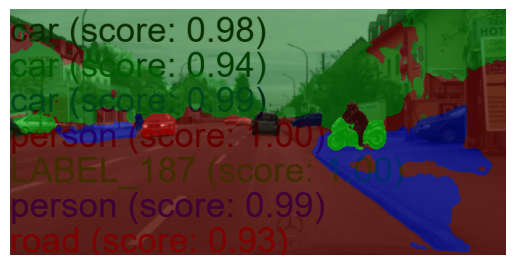

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont

# 假设 pip3 是你的图像分割 pipeline
data = '../data/img/cars.jpg'
res = pip3(data)

# 打开原始图像
image = Image.open(data)

# 创建一个与原始图像大小相同的空白图像来绘制掩码
mask_image = Image.new('RGBA', image.size, (0, 0, 0, 0))

# 创建一个绘图对象
draw = ImageDraw.Draw(image)
len_res=len(res)
sep=255//len_res
# 遍历每个分割结果
for i, result in enumerate(res):
    # 获取掩码并转换为 numpy 数组
    mask = np.array(result['mask'])
    
    # 为每个掩码选择一个颜色
    color_list = [0,0,0]
    for j in range(3):
        if i%3==j:
            color_list[j]=min(255, sep*(i+1))
    print(color_list)
    color = tuple(color_list)
    # color = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))
    
    # 创建一个与原始图像大小相同的空白掩码图像
    mask_layer = Image.new('RGBA', image.size, (0, 0, 0, 0))
    
    # 将掩码应用到原始图像上，设置透明度
    mask_array = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.uint8)
    mask_array[mask > 0] = np.array(color + (128,), dtype=np.uint8)
    mask_layer = Image.fromarray(mask_array)
    
    # 将掩码图像叠加到原始图像上
    mask_image = Image.alpha_composite(mask_image, mask_layer)
    
    # 在图像上添加标签
    label = result['label']
    score = result['score']
    text = f"{label} (score: {score:.2f})"
    
    font_size=50
    print(text)
    draw.text((0, font_size*i+1), text, fill=color, font=ImageFont.truetype("arial.ttf", font_size))

# 将掩码图像叠加到原始图像上
combined_image = Image.alpha_composite(image.convert('RGBA'), mask_image)

# 显示图像
plt.imshow(combined_image)
plt.axis('off')  # 关闭坐标轴
plt.show()